In [1]:
"""
Code to test a variety of transverse field coupling constants and observe their 
effect on convergence accuracy.
"""

import logging

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from qnade.utils import calculate_tfim_exact
from qnade.schemas import QNADEConfig
from qnade.optimize import optimize_qnade_network

logging.basicConfig(encoding="utf-8", level=logging.INFO)

INFO:root:iteration: 0
/Users/calebsanders/workspace/QNADE/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90
/Users/calebsanders/workspace/QNADE/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/calebsanders/workspace/QNADE/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex

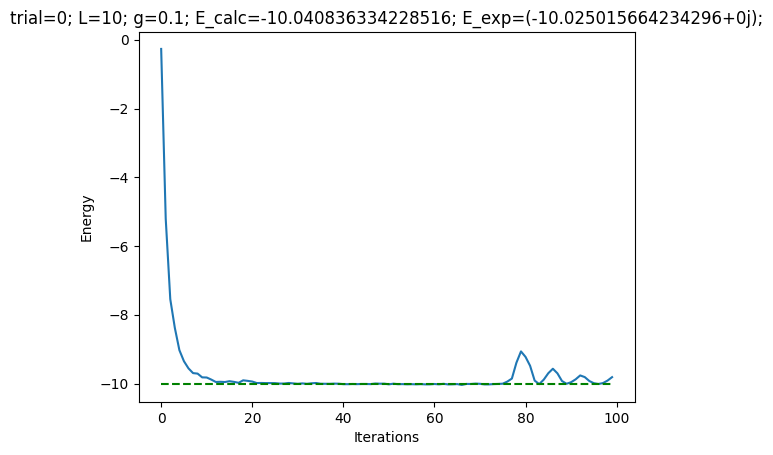

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


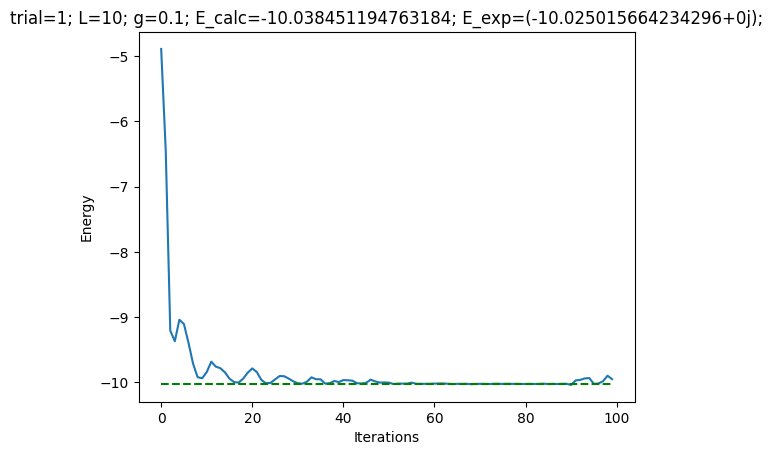

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.1
INFO:root:Minimum energy calculated: -10.040836334228516

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


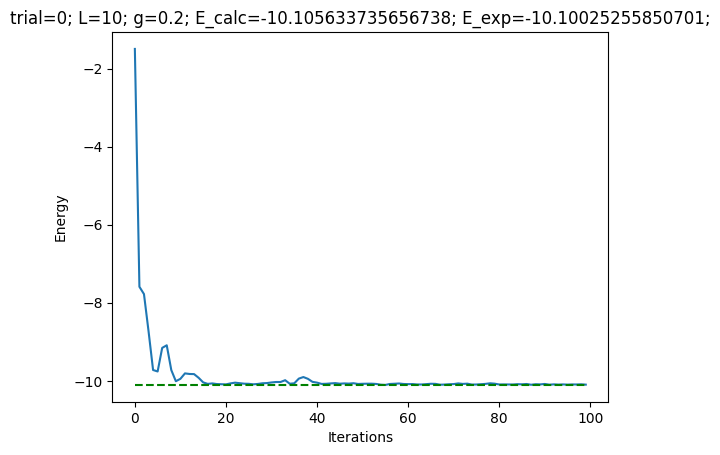

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


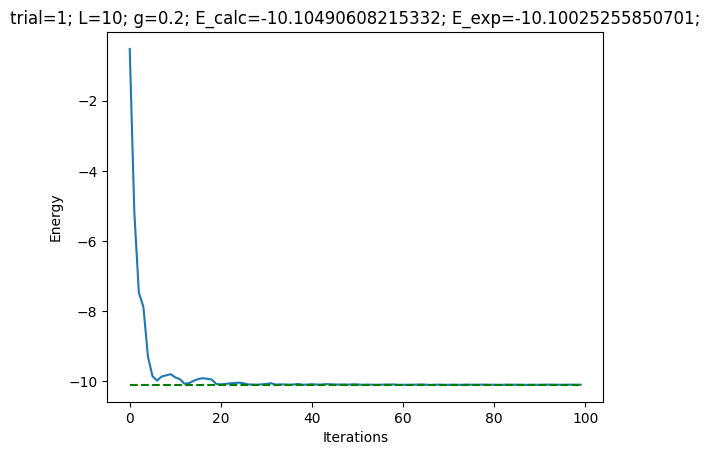

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.2
INFO:root:Minimum energy calculated: -10.105633735656738

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


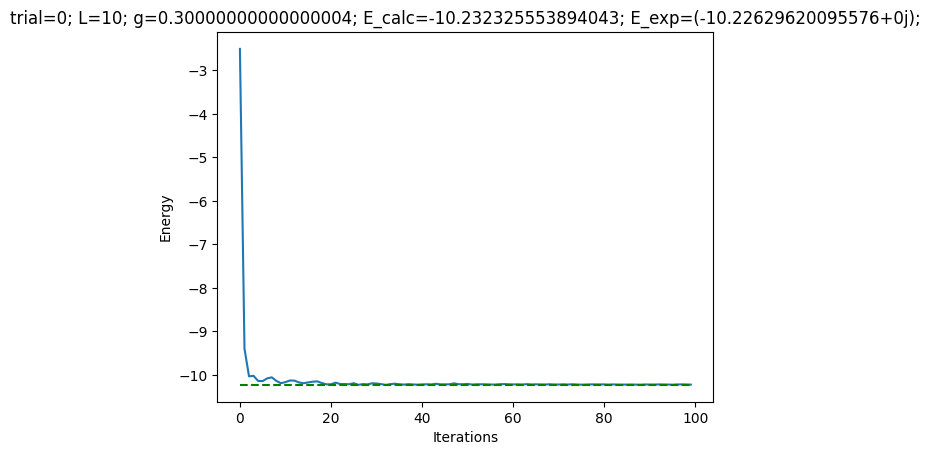

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


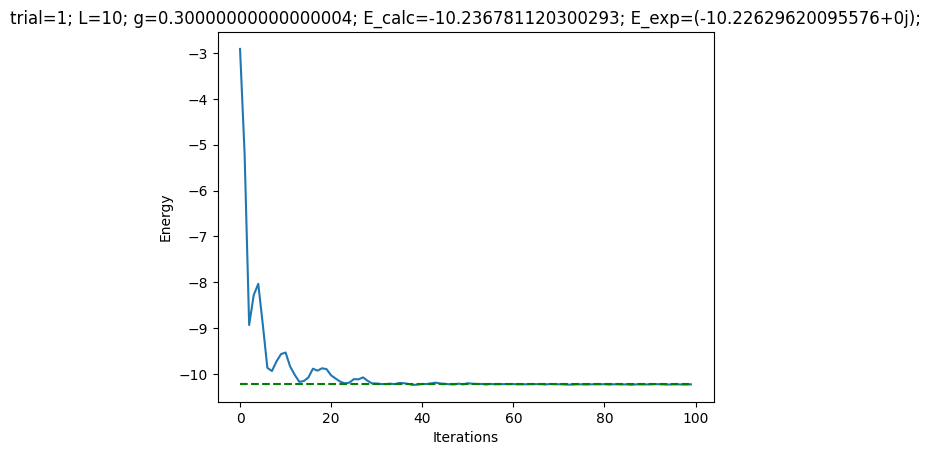

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.30000000000000004
INFO:root:Minimum energy calculated: -10.236781120300293

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


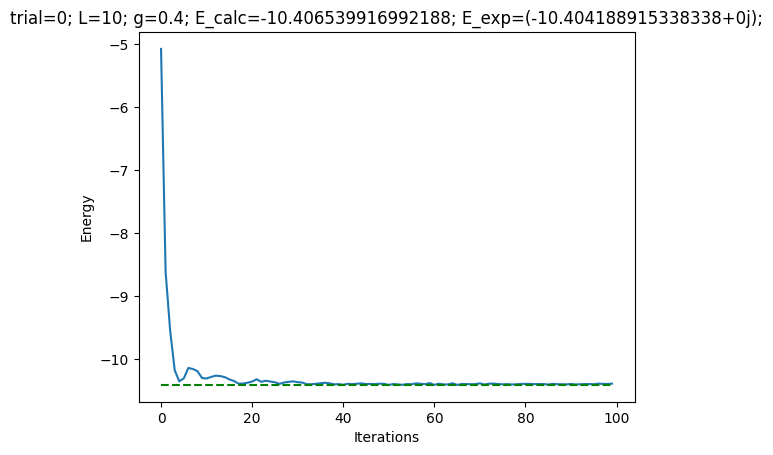

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


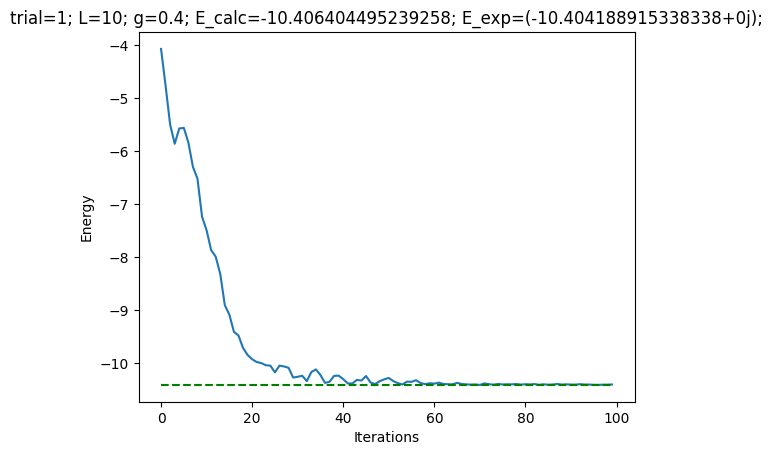

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.4
INFO:root:Minimum energy calculated: -10.406539916992188

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


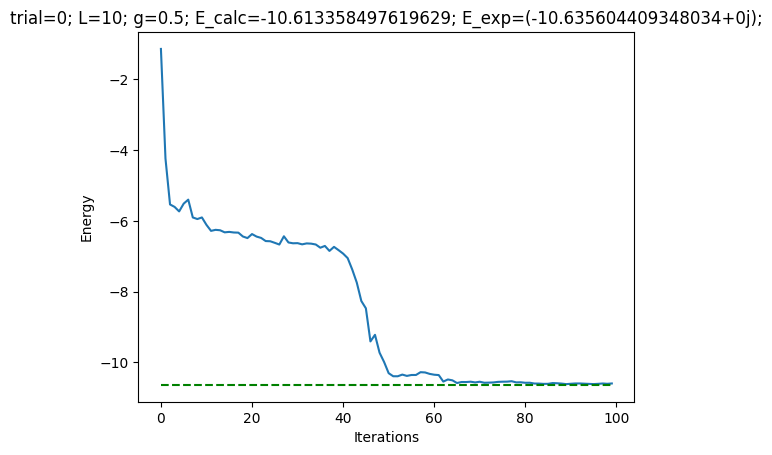

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


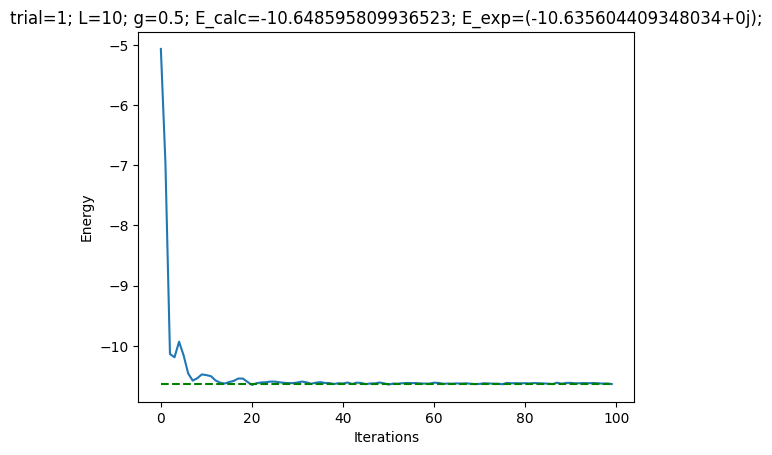

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.5
INFO:root:Minimum energy calculated: -10.648595809936523

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


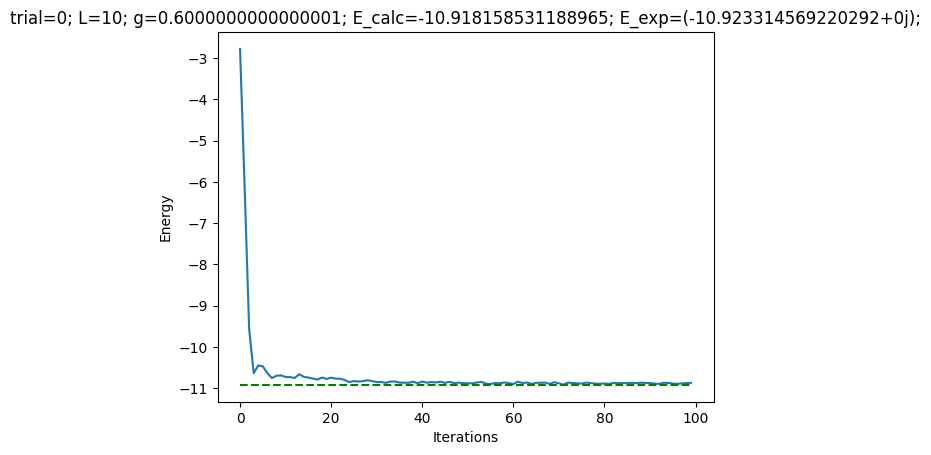

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


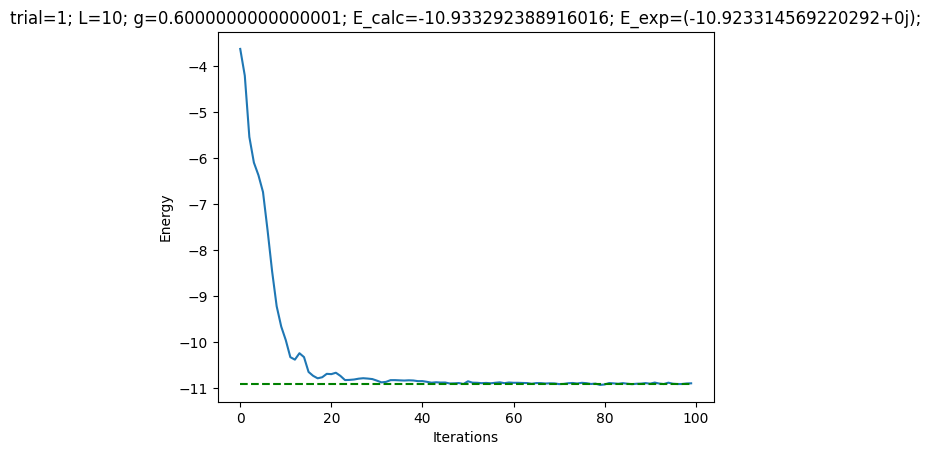

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.6000000000000001
INFO:root:Minimum energy calculated: -10.933292388916016

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


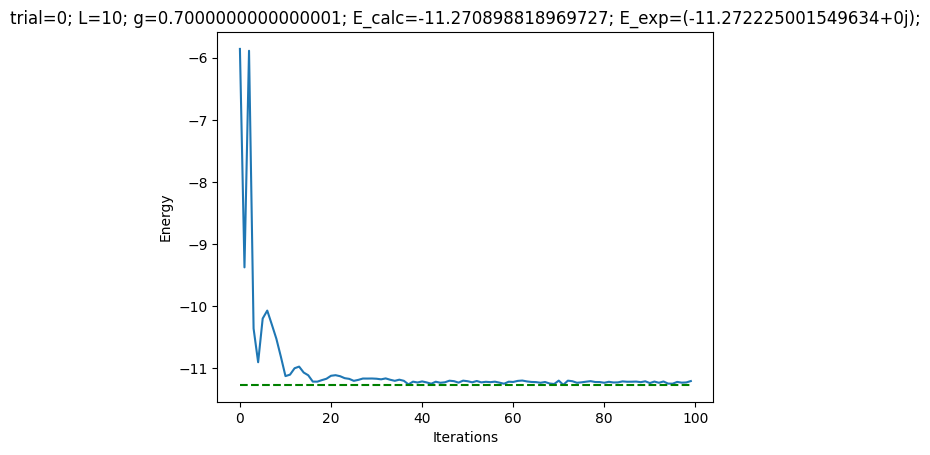

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


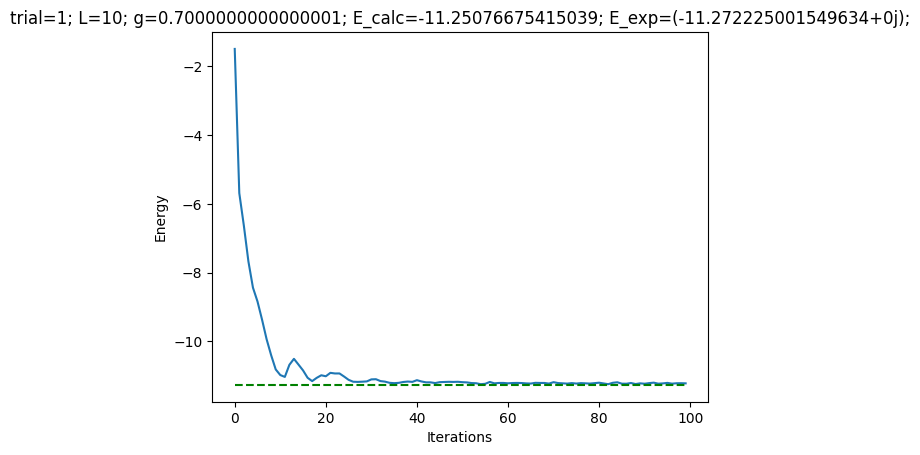

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.7000000000000001
INFO:root:Minimum energy calculated: -11.270898818969727

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


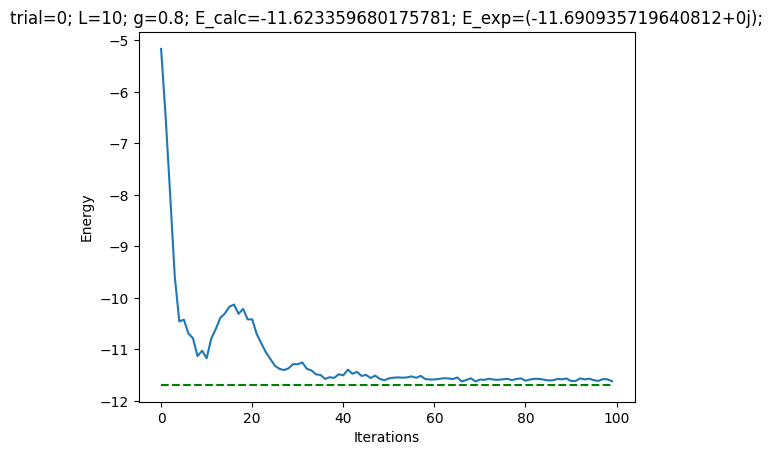

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


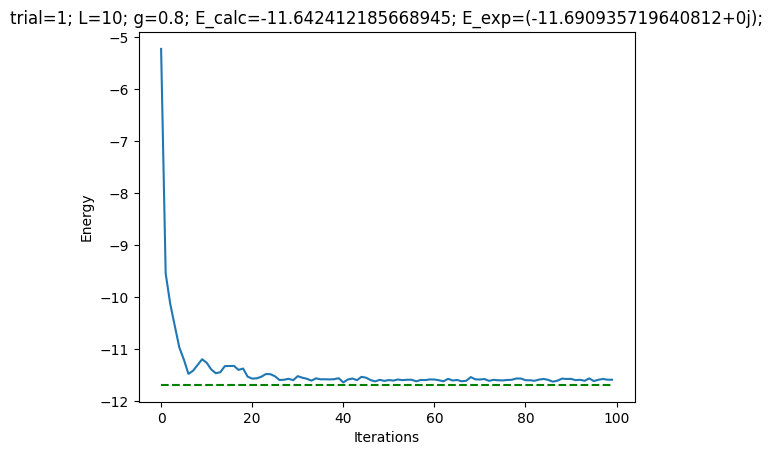

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.8
INFO:root:Minimum energy calculated: -11.642412185668945

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


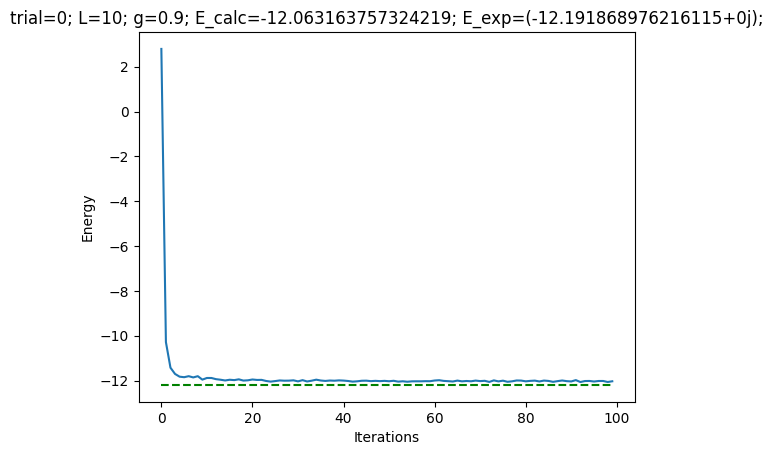

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


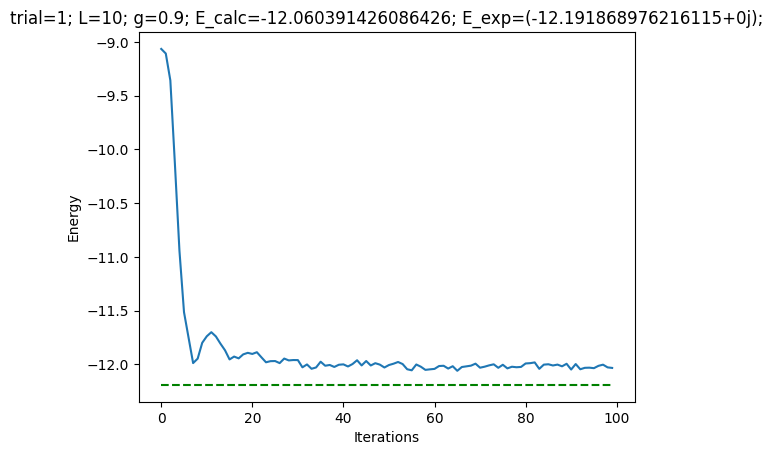

INFO:root:2 TRIALS COMPLETE FOR B_VAL 0.9
INFO:root:Minimum energy calculated: -12.063163757324219

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


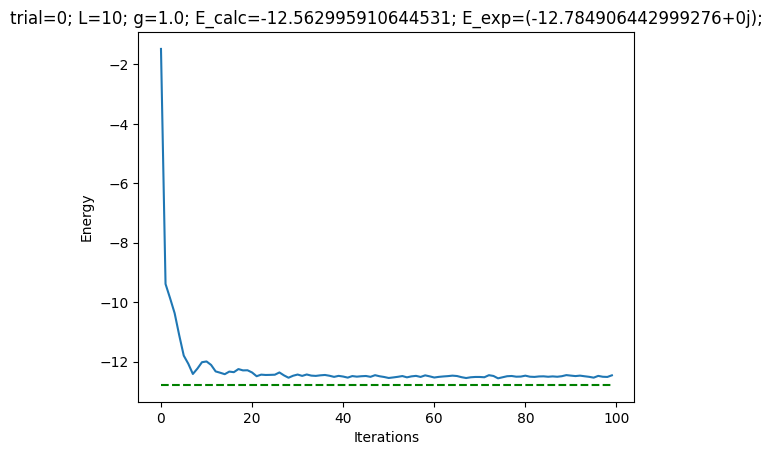

INFO:root:iteration: 0
INFO:root:iteration: 10
INFO:root:iteration: 20
INFO:root:iteration: 30
INFO:root:iteration: 40
INFO:root:iteration: 50
INFO:root:iteration: 60
INFO:root:iteration: 70
INFO:root:iteration: 80
INFO:root:iteration: 90


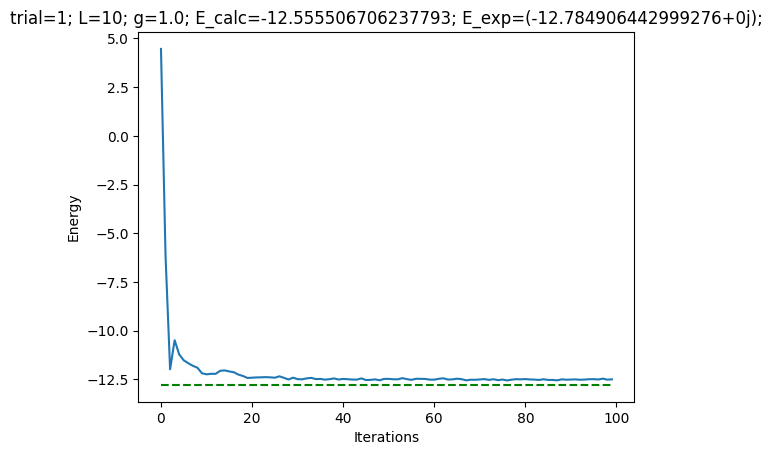

INFO:root:2 TRIALS COMPLETE FOR B_VAL 1.0
INFO:root:Minimum energy calculated: -12.562995910644531



In [2]:
L = 10
H = L*2
lr = 0.01
B_vals = np.arange(0.1, 1.1, 0.1)
num_trials_per_b_val = 2
number_of_training_iterations = 100
number_of_training_samples = 1000
ising_activation = 1

min_e_train = []
expected_energies = []
for b_val in B_vals:
    if L > 10:
        logging.info("System is too big for exact energy calculation.")
        expected_e = None
    else:
        expected_e = calculate_tfim_exact(L, b_val)
        expected_energies.append(expected_e)
    expected_e_plot = [expected_e for i in range(number_of_training_iterations)]

    trial_energies = []
    for trial in range(num_trials_per_b_val):
        config = QNADEConfig(
            number_of_qubits=L,
            hidden_layer_dimension=H,
            ising_activation=ising_activation,
            magnetic_field_coupling_strength=b_val,
            number_of_training_iterations=number_of_training_iterations,
            number_of_training_samples=number_of_training_samples,
            learning_rate=lr,
        )
        energies = optimize_qnade_network(config)
        ground_state_energy = min(energies)
        trial_energies.append(ground_state_energy)

        plt.figure()
        plt.title(
            "trial={}; L={}; g={}; E_calc={}; E_exp={};".format(trial, L, b_val, ground_state_energy, expected_e),
        )
        plt.plot(energies)
        plt.plot(expected_e_plot, "g--")
        plt.xlabel("Iterations")
        plt.ylabel("Energy")
        plt.show()

    logging.info(f"{num_trials_per_b_val} TRIALS COMPLETE FOR B_VAL {b_val}")
    logging.info(f"Minimum energy calculated: {min(trial_energies)}\n")
    min_e_train.append(min(trial_energies))

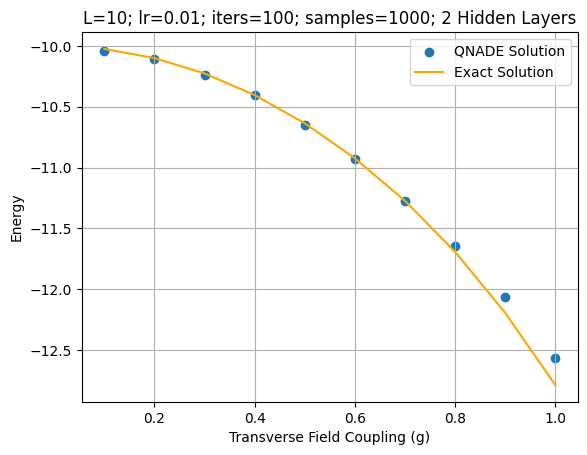

In [3]:
"""PLOT DATA"""

plt.scatter(B_vals, min_e_train, label="QNADE Solution")
plt.plot(B_vals, expected_energies, "orange", label="Exact Solution")
plt.grid()
plt.legend()
plt.xlabel("Transverse Field Coupling (g)")
plt.ylabel("Energy")
plt.title(f"L={L}; lr={lr}; iters={number_of_training_iterations}; samples={number_of_training_samples}; 2 Hidden Layers")
plt.savefig("g_test_2_H_Layer_L=10.png")
plt.show()